# Week 3 Project: End-to-End Insurance Risk Analytics & Predictive Modeling

## Task 3 : Hypothesis Testing on Risk Drivers

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

### Accessing the Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/kaim 6/week3/MachineLearningRating_v3.csv', delimiter="|") # Use the same delimiter when reading

<ipython-input-3-4151569796>:1: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'/content/drive/MyDrive/kaim 6/week3/MachineLearningRating_v3.csv', delimiter="|") # Use the same delimiter when reading


In [4]:
data.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [5]:
# Step 3: Feature Engineering
data['HasClaim'] = data['TotalClaims'] > 0
data['ClaimSeverity'] = data['TotalClaims'] / data['HasClaim'].replace({False: np.nan, True: 1})
data['Margin'] = data['TotalPremium'] - data['TotalClaims']

<ipython-input-5-2484660327>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['ClaimSeverity'] = data['TotalClaims'] / data['HasClaim'].replace({False: np.nan, True: 1})


### H₀:  No risk differences across provinces

In [6]:
# Grouping provinces by claim frequency
province_freq = data.groupby("Province")["HasClaim"].mean()

# ANOVA Test
groups = [data[data["Province"] == p]["HasClaim"] for p in data["Province"].dropna().unique()]
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA F = {f_stat:.3f}, p = {p_value:.5f}")
if p_value < 0.05:
    print("✅ Reject H₀: There ARE significant differences in claim frequency across provinces.")
else:
    print("❌ Fail to reject H₀: No significant differences across provinces.")


ANOVA F = 13.025, p = 0.00000
✅ Reject H₀: There ARE significant differences in claim frequency across provinces.


### H₀:  No risk differences across Zip Codes

In [7]:
# Only use zip codes with enough samples
zip_counts = data["PostalCode"].value_counts()
valid_zips = zip_counts[zip_counts > 50].index
zip_data = data[data["PostalCode"].isin(valid_zips)]

groups = [zip_data[zip_data["PostalCode"] == z]["HasClaim"] for z in valid_zips]
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA F = {f_stat:.3f}, p = {p_value:.5f}")
if p_value < 0.05:
    print("✅ Reject H₀: Significant risk differences across zip codes.")
else:
    print("❌ Fail to reject H₀.")


ANOVA F = 1.750, p = 0.00000
✅ Reject H₀: Significant risk differences across zip codes.


### H₀: No margin differences between Zip Codes

In [8]:
groups = [zip_data[zip_data["PostalCode"] == z]["Margin"] for z in valid_zips]
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA F = {f_stat:.3f}, p = {p_value:.5f}")
if p_value < 0.05:
    print("✅ Reject H₀: Significant margin differences between zip codes.")
else:
    print("❌ Fail to reject H₀.")


ANOVA F = 0.928, p = 0.93003
❌ Fail to reject H₀.


### H₀: No risk difference between Women and Men

In [9]:
# T-test for Gender risk difference
male = data[data["Gender"] == "Male"]["HasClaim"]
female = data[data["Gender"] == "Female"]["HasClaim"]

t_stat, p_value = stats.ttest_ind(male, female, nan_policy='omit')

print(f"T-test = {t_stat:.3f}, p = {p_value:.5f}")
if p_value < 0.05:
    print("✅ Reject H₀: Significant risk difference between men and women.")
else:
    print("❌ Fail to reject H₀.")


T-test = -inf, p = nan
❌ Fail to reject H₀.


## Task 4: Predictive Modeling for Claims and Premiums

### Importing Libraries

In [10]:
!pip install xgboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [12]:
data = pd.read_csv(r'/content/drive/MyDrive/kaim 6/week3/MachineLearningRating_v3.csv', delimiter="|") # Use the same delimiter when reading
df = pd.DataFrame(data)

# Introduce some actual claim values where TotalClaims is not NaN
claim_indices = df[df['TotalClaims'].isna()].index
df.loc[claim_indices, 'TotalClaims'] = np.random.rand(len(claim_indices)) * 50000 + 1000 # Fill NaNs with values

# Set some TotalClaims to 0 for the classification task
zero_claim_indices = np.random.choice(df.index, size=int(0.7 * len(df)), replace=False)
df.loc[zero_claim_indices, 'TotalClaims'] = 0

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

### Preparing and Processing Dataset

In [13]:
#### 2.1. Handling Missing Data & Data Type Conversions

# Drop 'NumberOfVehiclesInFleet' as it's entirely null
if 'NumberOfVehiclesInFleet' in df.columns:
    df = df.drop(columns=['NumberOfVehiclesInFleet'])

# Convert 'TransactionMonth' to datetime and extract year/month
df['TransactionYear'] = pd.to_datetime(df['TransactionMonth']).dt.year
df['TransactionMonthNum'] = pd.to_datetime(df['TransactionMonth']).dt.month
df = df.drop(columns=['TransactionMonth'])

# Convert boolean columns to int
for col in ['IsVATRegistered']:
    df[col] = df[col].astype(int)

# --- FIX START ---
# Define columns that should be treated as binary (Yes/No or True/False) AND EXPECT ONLY THOSE VALUES
# If a column should *only* contain 'Yes'/'No' (or boolean equivalents) and you encounter other strings,
# you must decide how to handle those other strings:
# 1. Map them to NaN and then impute.
# 2. Map them to a specific binary value if their meaning is implicitly Yes/No.
# 3. Treat them as a separate category if the column will be one-hot encoded.

# Based on your previous errors ('285700,00' and 'More than 6 months'), it suggests
# that some columns you *expect* to be binary (Yes/No) might also contain numeric strings or other descriptive strings.

# Option 1: Strictly binary (Yes/No) columns where other values are errors/unknowns
binary_flag_cols = [
    'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder'
]

# Process strict binary flag columns
for col in binary_flag_cols:
    if col in df.columns:
        # Create a mapping for known valid values
        mapping = {'Yes': 1, 'No': 0, True: 1, False: 0, 1:1, 0:0}
        # Apply the mapping, setting non-mappable values (like 'More than 6 months', numeric strings) to NaN
        df[col] = df[col].map(mapping)

        # Impute remaining NaNs with the mode (most frequent *valid* category)
        if df[col].isnull().sum() > 0:
            # Ensure mode is taken from valid 0/1 values, or a NaN
            # Use value_counts(dropna=True) to find mode among existing non-NaN values
            mode_val = df[col].dropna().mode()[0] if not df[col].dropna().empty else 0 # Default to 0 if all are NaN
            df[col] = df[col].astype(float).fillna(mode_val).astype(int) # Chain fillna and astype for robustness

# Option 2: Columns like 'CapitalOutstanding' or 'NewVehicle' which might be intended as AMOUNT/DATE but also contain 'Yes'/'No' or other descriptive strings.
# This requires a more flexible approach:
# For 'CapitalOutstanding': It sounds like a numeric amount, but has 'Yes'/'No' and descriptive strings.
# We'll prioritize converting it to numeric. 'Yes'/'No' and other non-numeric strings will become NaN.
if 'CapitalOutstanding' in df.columns:
    def clean_capital_outstanding(value):
        if pd.isna(value):
            return np.nan
        s_val = str(value).strip().lower()
        if s_val in ['yes', 'no', 'true', 'false']: # Treat 'Yes'/'No' as unquantifiable amounts, convert to NaN
            return np.nan # Or convert to 0, depending on business logic for 'No outstanding capital'
        try:
            # Replace comma decimal separator with period and convert to float
            return float(s_val.replace(',', '.'))
        except ValueError:
            return np.nan # If it's 'More than 6 months' or other non-numeric string, set to NaN

    df['CapitalOutstanding'] = df['CapitalOutstanding'].apply(clean_capital_outstanding)

    # After cleaning, impute numerical missing values (from initial NaNs or conversion failures) with the median
    if df['CapitalOutstanding'].isnull().sum() > 0:
        median_val = df['CapitalOutstanding'].median()
        df['CapitalOutstanding'] = df['CapitalOutstanding'].fillna(median_val)
    df['CapitalOutstanding'] = df['CapitalOutstanding'].astype(float) # Keep as float for monetary amounts

# For 'NewVehicle': If 'More than 6 months' is a valid category for this column alongside 'Yes'/'No',
# then this column should be treated as a categorical column and one-hot encoded later,
# not converted to int(0/1). If 'More than 6 months' is an error, treat as NaN.
# Given its presence, it suggests it's a categorical feature that needs proper handling.
# Let's revert 'NewVehicle' to be treated as a categorical column, mapping 'Yes'/'No' to meaningful labels
# and leaving 'More than 6 months' as is for OHE.

if 'NewVehicle' in df.columns:
    # Convert bools to 'Yes'/'No' strings for consistency before OHE
    df['NewVehicle'] = df['NewVehicle'].replace({True: 'Yes', False: 'No'})
    # Impute NaNs with mode for categorical columns
    if df['NewVehicle'].isnull().sum() > 0:
        df['NewVehicle'] = df['NewVehicle'].fillna(df['NewVehicle'].mode()[0])


# Impute numerical missing values with the median (robust to outliers)
# This will now include CapitalOutstanding, which is now float.
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Impute categorical missing values with the mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

print(f"Missing values after initial imputation: \n{df.isnull().sum().sum()}")
print(df.info())

Missing values after initial imputation: 
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   IsVATRegistered           1000098 non-null  int64  
 3   Citizenship               1000098 non-null  object 
 4   LegalType                 1000098 non-null  object 
 5   Title                     1000098 non-null  object 
 6   Language                  1000098 non-null  object 
 7   Bank                      1000098 non-null  object 
 8   AccountType               1000098 non-null  object 
 9   MaritalStatus             1000098 non-null  object 
 10  Gender                    1000098 non-null  object 
 11  Country                   1000098 non-null  object 
 12  Province                  1000098 non-nu

### Encoding Categorical Data and Train-Test Split Setup

In [14]:
# Identify columns to drop (IDs, original date columns, potentially high-cardinality nominals if not useful after encoding)
cols_to_drop_common = ['UnderwrittenCoverID', 'PolicyID', 'PostalCode', 'VehicleIntroDate']
# Add original string columns that were converted to numeric/datetime
cols_to_drop_common.extend([col for col in ['TransactionMonth'] if col in df.columns])


# For Claim Severity Prediction: Only policies with claims > 0
claim_severity_df = df[df['TotalClaims'] > 0].copy()
X_claim_severity = claim_severity_df.drop(columns=['TotalClaims', 'CalculatedPremiumPerTerm'] + cols_to_drop_common, errors='ignore')
y_claim_severity = claim_severity_df['TotalClaims']

# For Premium Optimization: Predict CalculatedPremiumPerTerm
X_premium = df.drop(columns=['CalculatedPremiumPerTerm', 'TotalClaims'] + cols_to_drop_common, errors='ignore')
y_premium = df['CalculatedPremiumPerTerm']

# For Claim Probability Prediction: Binary target
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
X_claim_prob = df.drop(columns=['HasClaim', 'TotalClaims', 'CalculatedPremiumPerTerm'] + cols_to_drop_common, errors='ignore')
y_claim_prob = df['HasClaim']

# Identify categorical columns for encoding (after dropping target/ID columns)
# Ensure consistent categorical columns across all X dataframes before encoding to avoid misalignment
all_categorical_cols = X_claim_prob.select_dtypes(include='object').columns

# Apply One-Hot Encoding
# Use a single OneHotEncoder to ensure consistent columns across all datasets
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # handle_unknown='ignore' for unseen categories in test
ohe.fit(df[all_categorical_cols]) # Fit on the full dataframe to capture all possible categories

# Transform each dataset
X_claim_severity_encoded = pd.DataFrame(ohe.transform(X_claim_severity[all_categorical_cols]),
                                        columns=ohe.get_feature_names_out(all_categorical_cols),
                                        index=X_claim_severity.index)
X_claim_severity_final = pd.concat([X_claim_severity.select_dtypes(include=np.number), X_claim_severity_encoded], axis=1)


X_premium_encoded = pd.DataFrame(ohe.transform(X_premium[all_categorical_cols]),
                                 columns=ohe.get_feature_names_out(all_categorical_cols),
                                 index=X_premium.index)
X_premium_final = pd.concat([X_premium.select_dtypes(include=np.number), X_premium_encoded], axis=1)


X_claim_prob_encoded = pd.DataFrame(ohe.transform(X_claim_prob[all_categorical_cols]),
                                    columns=ohe.get_feature_names_out(all_categorical_cols),
                                    index=X_claim_prob.index)
X_claim_prob_final = pd.concat([X_claim_prob.select_dtypes(include=np.number), X_claim_prob_encoded], axis=1)

# Align columns to ensure all dataframes have the same columns in the same order
# This is crucial if a category appears in train but not test, or vice-versa
# Get all columns from all three final dataframes
all_columns_union = list(set(X_claim_severity_final.columns) | set(X_premium_final.columns) | set(X_claim_prob_final.columns))
all_columns_union.sort() # Ensure consistent order

# Reindex all dataframes to have the union of columns, filling missing with 0 (for one-hot encoded features)
X_claim_severity_final = X_claim_severity_final.reindex(columns=all_columns_union, fill_value=0)
X_premium_final = X_premium_final.reindex(columns=all_columns_union, fill_value=0)
X_claim_prob_final = X_claim_prob_final.reindex(columns=all_columns_union, fill_value=0)


# Standardize numerical features after encoding
# Exclude binary (0/1) columns from scaling.
# 'IsVATRegistered' and the processed `binary_flag_cols` are already 0/1 integers.
# 'CapitalOutstanding' is now a float (amount) and should be scaled.
binary_flag_cols_final = [
    'IsVATRegistered', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder'
]
# Ensure these columns exist before trying to exclude them
binary_flag_cols_final = [col for col in binary_flag_cols_final if col in X_claim_prob_final.columns]

numerical_cols_to_scale = X_claim_prob_final.select_dtypes(include=np.number).columns.drop(
    binary_flag_cols_final, errors='ignore' # Use errors='ignore' if some columns might not exist in the filtered list
)


scaler = StandardScaler()

# Fit on the largest dataset (X_claim_prob_final, as it contains all original rows) and transform all
# Only scale columns that exist in the respective dataframe
X_claim_prob_final[numerical_cols_to_scale.intersection(X_claim_prob_final.columns)] = scaler.fit_transform(X_claim_prob_final[numerical_cols_to_scale.intersection(X_claim_prob_final.columns)])
X_premium_final[numerical_cols_to_scale.intersection(X_premium_final.columns)] = scaler.transform(X_premium_final[numerical_cols_to_scale.intersection(X_premium_final.columns)])
X_claim_severity_final[numerical_cols_to_scale.intersection(X_claim_severity_final.columns)] = scaler.transform(X_claim_severity_final[numerical_cols_to_scale.intersection(X_claim_severity_final.columns)])


print(f"Shape after encoding and scaling (Claim Severity): {X_claim_severity_final.shape}")
print(f"Shape after encoding and scaling (Premium Optimization): {X_premium_final.shape}")
print(f"Shape after encoding and scaling (Claim Probability): {X_claim_prob_final.shape}")

Shape after encoding and scaling (Claim Severity): (782, 696)
Shape after encoding and scaling (Premium Optimization): (1000098, 696)
Shape after encoding and scaling (Claim Probability): (1000098, 696)


### Train-Test Split

In [15]:
### 2.4. Train-Test Split

# Train-Test Split for Claim Severity Prediction
X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_claim_severity_final, y_claim_severity, test_size=0.3, random_state=42
)

# Train-Test Split for Premium Optimization
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(
    X_premium_final, y_premium, test_size=0.3, random_state=42
)

# Train-Test Split for Claim Probability Prediction (stratified to maintain class balance)
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(
    X_claim_prob_final, y_claim_prob, test_size=0.3, random_state=42, stratify=y_claim_prob
)

print(f"Claim Severity - Train: {X_train_cs.shape}, Test: {X_test_cs.shape}")
print(f"Premium Optimization - Train: {X_train_pr.shape}, Test: {X_test_pr.shape}")
print(f"Claim Probability - Train: {X_train_cp.shape}, Test: {X_test_cp.shape}")

Claim Severity - Train: (547, 696), Test: (235, 696)
Premium Optimization - Train: (700068, 696), Test: (300030, 696)
Claim Probability - Train: (700068, 696), Test: (300030, 696)


### 3. Statistical Modeling


In [16]:
### 3. Statistical Modeling

#### 3.1. Claim Severity Prediction (Regression Models)

# Initialize models
lr_cs = LinearRegression()
rf_cs = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_cs = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

models_cs = {
    "Linear Regression": lr_cs,
    "Random Forest": rf_cs,
    "XGBoost": xgb_cs
}

results_cs = {}

print("--- Claim Severity Prediction Models ---")
for name, model in models_cs.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_cs, y_train_cs)
    y_pred_cs = model.predict(X_test_cs)

    rmse_cs = np.sqrt(mean_squared_error(y_test_cs, y_pred_cs))
    r2_cs = r2_score(y_test_cs, y_pred_cs)

    results_cs[name] = {"RMSE": rmse_cs, "R-squared": r2_cs}
    print(f"{name} - RMSE: {rmse_cs:.4f}, R-squared: {r2_cs:.4f}")

# Display results in a DataFrame
results_df_cs = pd.DataFrame(results_cs).T
print("\n--- Claim Severity Model Evaluation Results ---")
print(results_df_cs)

--- Claim Severity Prediction Models ---

Training Linear Regression...
Linear Regression - RMSE: 102294993243.7771, R-squared: -5476684027485.1553

Training Random Forest...
Random Forest - RMSE: 38278.8574, R-squared: 0.2331

Training XGBoost...
XGBoost - RMSE: 41259.7279, R-squared: 0.1090

--- Claim Severity Model Evaluation Results ---
                           RMSE     R-squared
Linear Regression  1.022950e+11 -5.476684e+12
Random Forest      3.827886e+04  2.331210e-01
XGBoost            4.125973e+04  1.090329e-01


### Premium Optimization (Naive Approach: Predicting CalculatedPremiumPerTerm)



In [17]:
# Initialize models for Premium Optimization
lr_pr = LinearRegression()
rf_pr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_pr = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

models_pr = {
    "Linear Regression": lr_pr,
    "Random Forest": rf_pr,
    "XGBoost": xgb_pr
}

results_pr = {}

print("\n--- Premium Optimization (Naive) Models ---")
for name, model in models_pr.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_pr, y_train_pr)
    y_pred_pr = model.predict(X_test_pr)

    rmse_pr = np.sqrt(mean_squared_error(y_test_pr, y_pred_pr))
    r2_pr = r2_score(y_test_pr, y_pred_pr)

    results_pr[name] = {"RMSE": rmse_pr, "R-squared": r2_pr}
    print(f"{name} - RMSE: {rmse_pr:.4f}, R-squared: {r2_pr:.4f}")

# Display results in a DataFrame
results_df_pr = pd.DataFrame(results_pr).T
print("\n--- Premium Optimization (Naive) Model Evaluation Results ---")
print(results_df_pr)


--- Premium Optimization (Naive) Models ---

Training Linear Regression...
Linear Regression - RMSE: 7207.6369, R-squared: -358.2540

Training Random Forest...
Random Forest - RMSE: 15.0932, R-squared: 0.9984

Training XGBoost...
XGBoost - RMSE: 24.4522, R-squared: 0.9959

--- Premium Optimization (Naive) Model Evaluation Results ---
                          RMSE   R-squared
Linear Regression  7207.636897 -358.254022
Random Forest        15.093164    0.998425
XGBoost              24.452220    0.995865


### Advanced Task: Probability of Claim Occurring (Binary Classification)


--- Claim Probability Prediction Models ---

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9992, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC-AUC: 0.8730

Training Random Forest Classifier...
Random Forest Classifier - Accuracy: 0.9989, Precision: 0.0115, Recall: 0.0043, F1-Score: 0.0062, ROC-AUC: 0.5332

Training XGBoost Classifier...
XGBoost Classifier - Accuracy: 0.9992, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC-AUC: 0.9023

--- Claim Probability Model Evaluation Results ---
                          Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression       0.999213   0.000000  0.000000  0.000000  0.873033
Random Forest Classifier  0.998933   0.011494  0.004255  0.006211  0.533182
XGBoost Classifier        0.999213   0.000000  0.000000  0.000000  0.902336


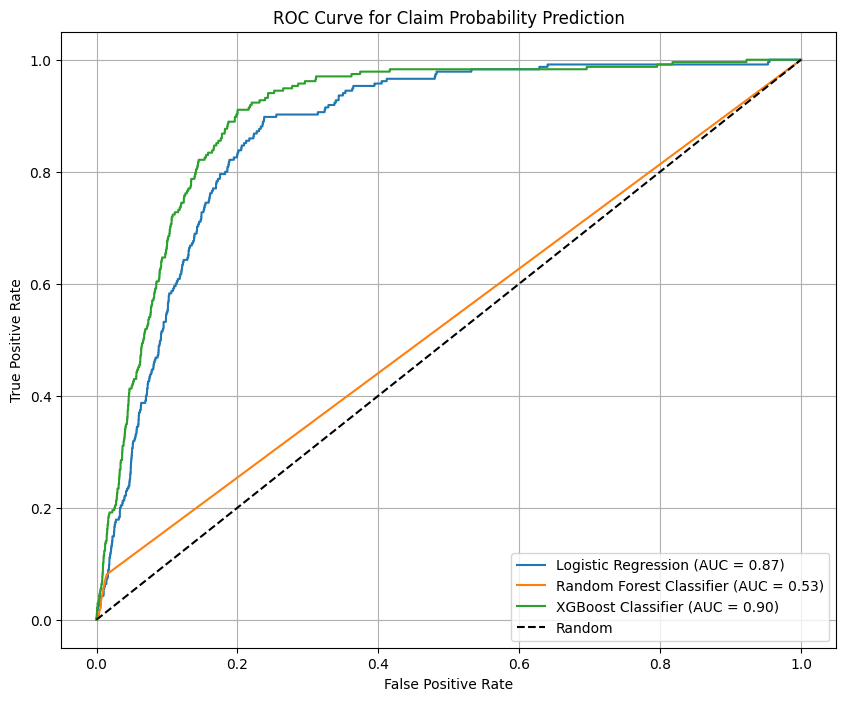

In [18]:
# Initialize classification models
lr_cp = LogisticRegression(solver='liblinear', random_state=42, n_jobs=-1)
rf_cp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb_cp = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

models_cp = {
    "Logistic Regression": lr_cp,
    "Random Forest Classifier": rf_cp,
    "XGBoost Classifier": xgb_cp
}

results_cp = {}

print("\n--- Claim Probability Prediction Models ---")
for name, model in models_cp.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_cp, y_train_cp)
    y_pred_cp = model.predict(X_test_cp)
    y_prob_cp = model.predict_proba(X_test_cp)[:, 1] # Probability of the positive class

    accuracy_cp = accuracy_score(y_test_cp, y_pred_cp)
    precision_cp = precision_score(y_test_cp, y_pred_cp)
    recall_cp = recall_score(y_test_cp, y_pred_cp)
    f1_cp = f1_score(y_test_cp, y_pred_cp)
    roc_auc_cp = roc_auc_score(y_test_cp, y_prob_cp)

    results_cp[name] = {
        "Accuracy": accuracy_cp,
        "Precision": precision_cp,
        "Recall": recall_cp,
        "F1-Score": f1_cp,
        "ROC-AUC": roc_auc_cp
    }
    print(f"{name} - Accuracy: {accuracy_cp:.4f}, Precision: {precision_cp:.4f}, Recall: {recall_cp:.4f}, F1-Score: {f1_cp:.4f}, ROC-AUC: {roc_auc_cp:.4f}")

# Display results in a DataFrame
results_df_cp = pd.DataFrame(results_cp).T
print("\n--- Claim Probability Model Evaluation Results ---")
print(results_df_cp)

# Plot ROC Curves for Claim Probability Models
plt.figure(figsize=(10, 8))
for name, model in models_cp.items():
    y_prob = model.predict_proba(X_test_cp)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_cp, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results_cp[name]["ROC-AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Claim Probability Prediction')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix (per model)

<Figure size 500x400 with 0 Axes>

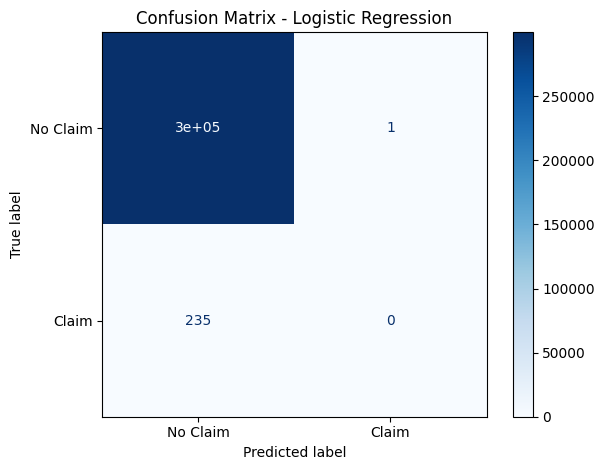

<Figure size 500x400 with 0 Axes>

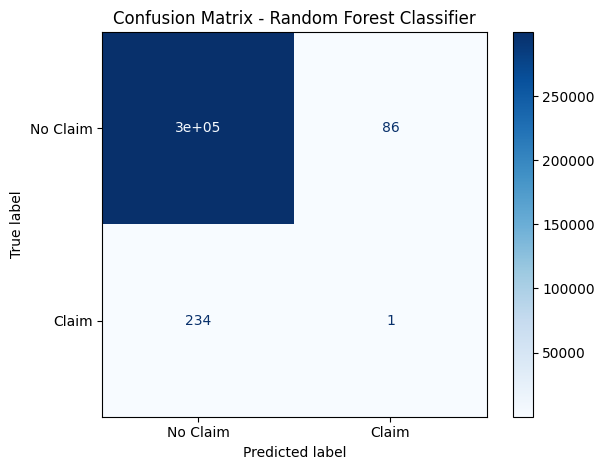

<Figure size 500x400 with 0 Axes>

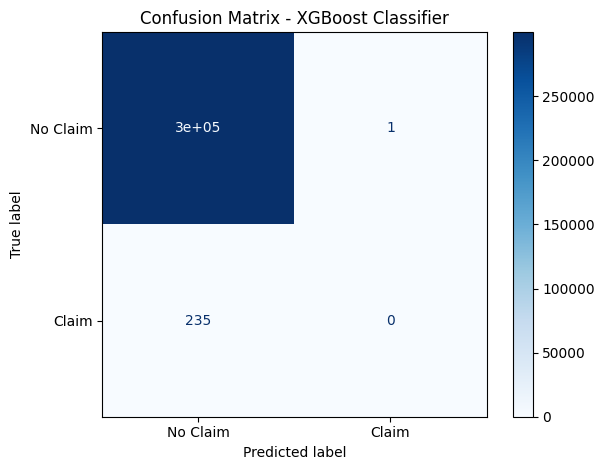

In [21]:
for name, model in models_cp.items():
    y_pred = model.predict(X_test_cp)
    plt.figure(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test_cp, y_pred, display_labels=["No Claim", "Claim"], cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


### Precision-Recall Curve

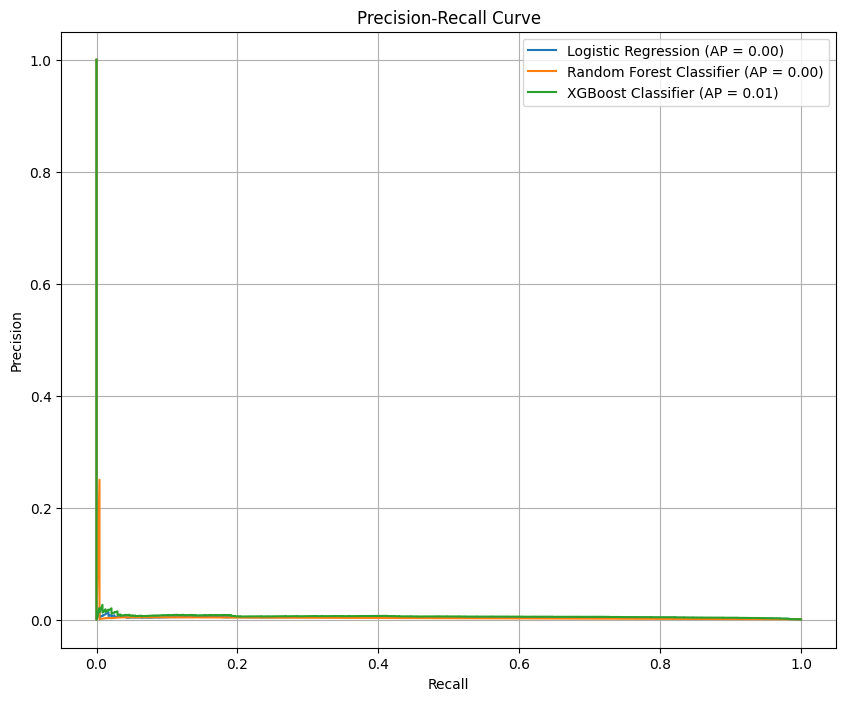

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for name, model in models_cp.items():
    y_score = model.predict_proba(X_test_cp)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test_cp, y_score)
    avg_prec = average_precision_score(y_test_cp, y_score)
    plt.plot(recall, precision, label=f'{name} (AP = {avg_prec:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


### Feature Importance (Random Forest & XGBoost)

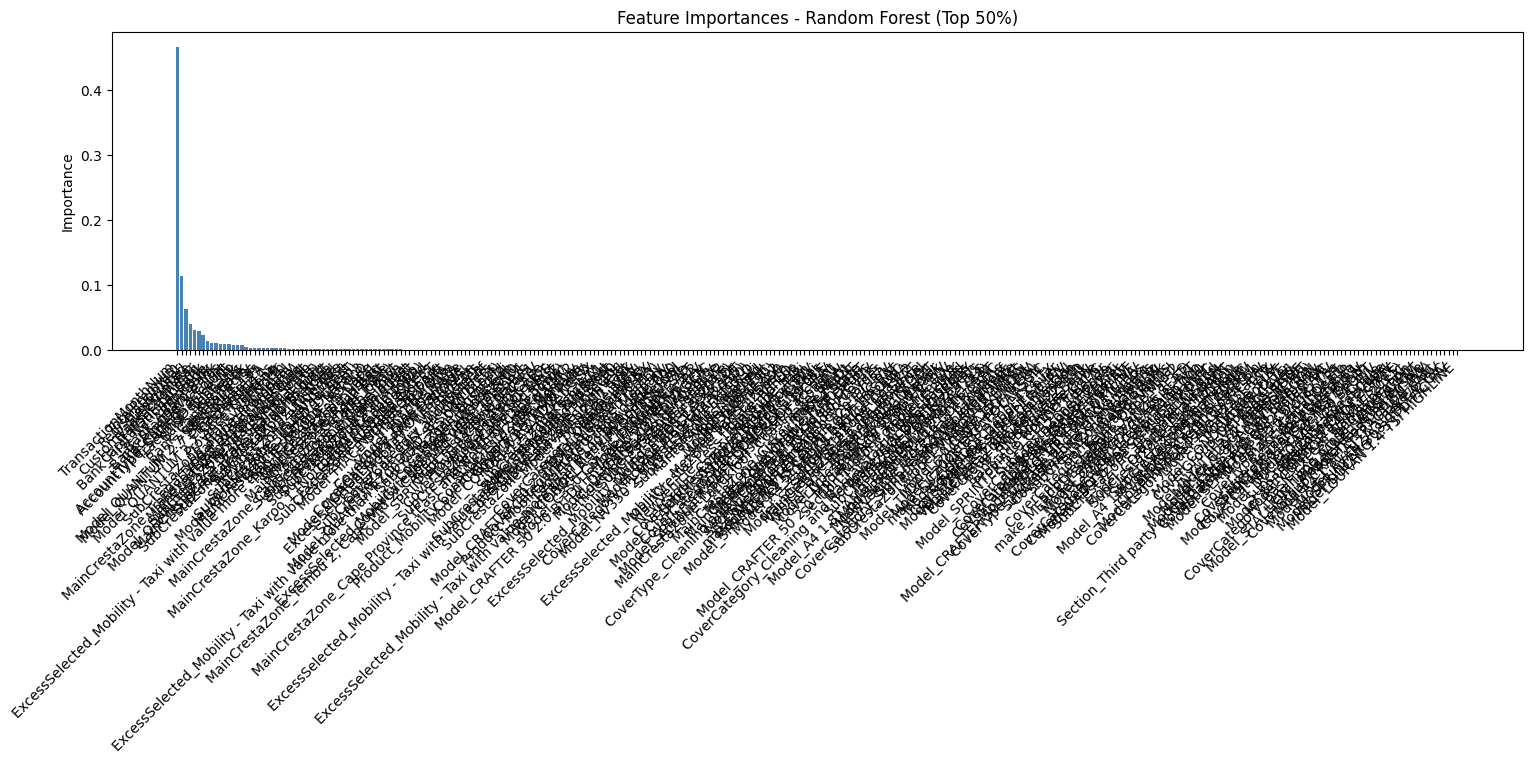

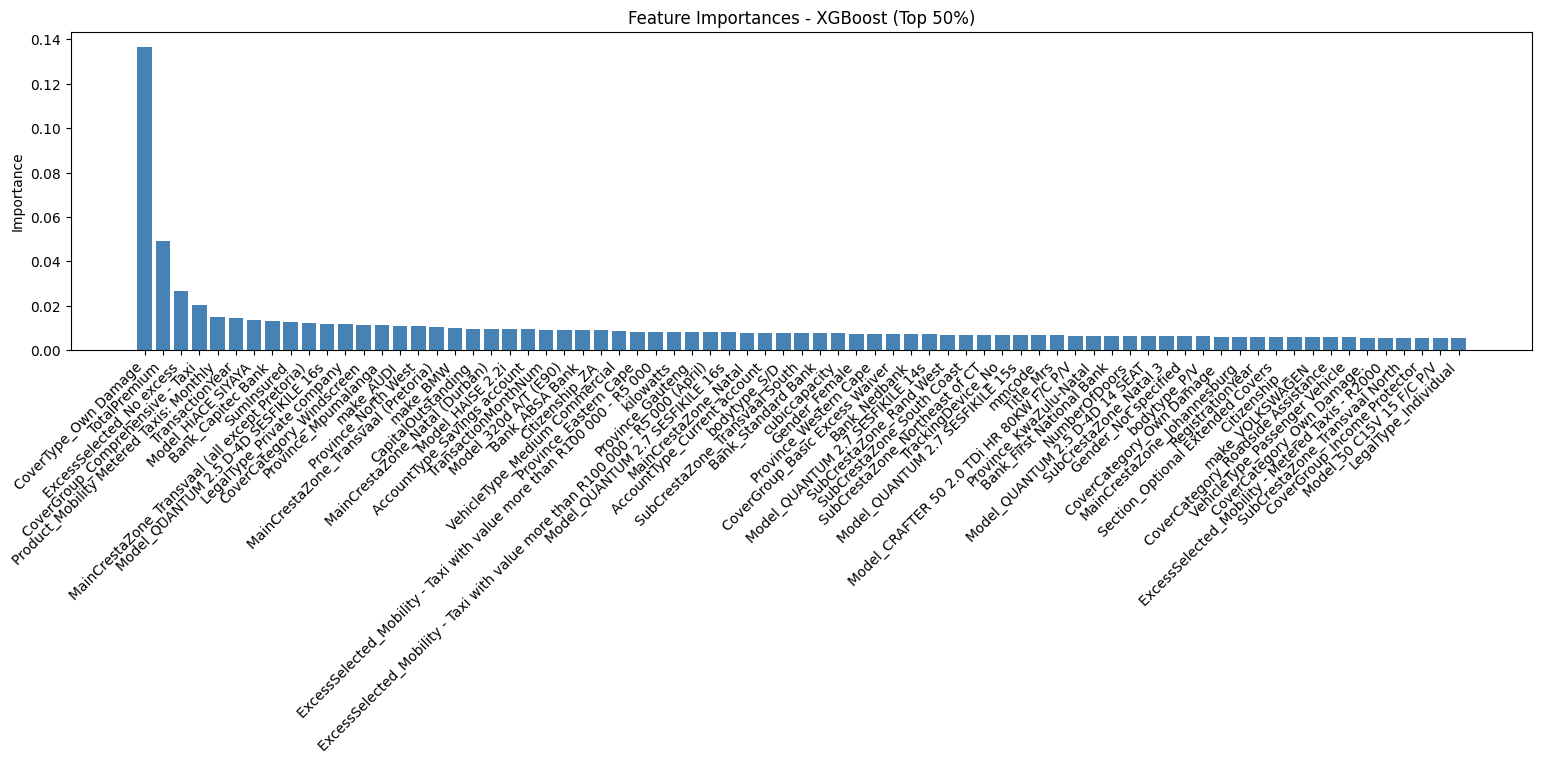

In [37]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Filter non-zero importances
        non_zero_indices = indices[importances[indices] > 0]

        # Calculate top 50% cutoff
        half_count = max(1, len(non_zero_indices) // 2)
        top_indices = non_zero_indices[:half_count]

        top_importances = importances[top_indices]
        top_features = np.array(feature_names)[top_indices]

        plt.figure(figsize=(16, 8))  # Balanced width and height
        plt.bar(range(len(top_importances)), top_importances, align='center', color='steelblue')
        plt.xticks(range(len(top_importances)), top_features, rotation=45, ha='right')
        plt.title(f'Feature Importances - {model_name} (Top 50%)')
        plt.ylabel('Importance')
        plt.tight_layout(pad=2.0)
        plt.show()




plot_feature_importance(rf_cp, "Random Forest", X_train_cp.columns)
plot_feature_importance(xgb_cp, "XGBoost", X_train_cp.columns)
